### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from IPython.display import Image
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Forwards stepwise regression

In [3]:
# read earthquake data from file in current directory
earthquakeData = pd.read_csv('disp_data.csv')

# selecting 10 spectral acceleration values along with other earthquake features to minimize backwards selection time
earthquakeData = earthquakeData[['KY1','T','durav','AIav','M','ClstD','vs30','PGA','PGV','PGD','T0010S','T0020S','T0050S','T0070S','T0100S','T0200S','T0300S','T0400S','sa15','sa20','sa25','sa30','sa13','sa14','sa16','sa17','sa18','sa10','sa11','sa12','Disp']]

earthquakeData = earthquakeData[earthquakeData['Disp']>0] # need to drop zeroes columns before doing log transformation

earthquakeData_log=np.log(earthquakeData.drop(columns=['T','M']))
earthquakeData_log['T']=earthquakeData['T']
earthquakeData_log['M']=earthquakeData['M']

# perform forwards feature selection to find best features for estimating displacement
y = np.log(earthquakeData['Disp'].to_numpy())
X = earthquakeData_log.drop(columns='Disp')
sfs = SFS(                              # selects one predictor at a time to create a model
    estimator = LinearRegression(),     # uses linear regression model
    k_features=10,                      # maximum size of key features
    forward=True,                       # forward stepwise regression (keep adding features, false removes features one at a time)
    scoring="r2"                        # rates effectiveness of predictors using r-squared value
)
sfs.fit(X,y)

res = pd.DataFrame.from_dict(sfs.get_metric_dict()).T   # visualizes results in a pandas dataframe
res

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)","[0.20489494536481467, 0.24264296502640315, 0.2...",0.286685,"(PGV,)",0.122792,0.095536,0.047768
2,"(0, 6)","[0.5941216887740215, 0.602283984875017, 0.4908...",0.57964,"(KY1, PGV)",0.061132,0.047563,0.023781
3,"(0, 6, 25)","[0.7127837139566019, 0.7457091707166064, 0.697...",0.737954,"(KY1, PGV, sa10)",0.039012,0.030353,0.015176
4,"(0, 6, 25, 28)","[0.7146326335482784, 0.746003846818968, 0.7185...",0.74549,"(KY1, PGV, sa10, T)",0.037306,0.029025,0.014512
5,"(0, 1, 6, 25, 28)","[0.7315943460573489, 0.7563501096193452, 0.722...",0.753624,"(KY1, durav, PGV, sa10, T)",0.033324,0.025927,0.012964
6,"(0, 1, 6, 25, 27, 28)","[0.7360995246967417, 0.7598322320958666, 0.726...",0.756655,"(KY1, durav, PGV, sa10, sa12, T)",0.031103,0.0242,0.0121
7,"(0, 1, 6, 12, 25, 27, 28)","[0.7357929068380697, 0.7627402467323613, 0.729...",0.759108,"(KY1, durav, PGV, T0100S, sa10, sa12, T)",0.031513,0.024519,0.012259
8,"(0, 1, 2, 6, 12, 25, 27, 28)","[0.7414077971854564, 0.7683540799007079, 0.733...",0.763567,"(KY1, durav, AIav, PGV, T0100S, sa10, sa12, T)",0.031735,0.024691,0.012345
9,"(0, 1, 2, 6, 12, 19, 25, 27, 28)","[0.7429717813918642, 0.7708758322773576, 0.736...",0.765702,"(KY1, durav, AIav, PGV, T0100S, sa30, sa10, sa...",0.032031,0.024922,0.012461
10,"(0, 1, 2, 6, 10, 12, 19, 25, 27, 28)","[0.7443258309178346, 0.7711337566229365, 0.735...",0.766533,"(KY1, durav, AIav, PGV, T0050S, T0100S, sa30, ...",0.032591,0.025357,0.012678


Text(0, 0.5, 'r2')

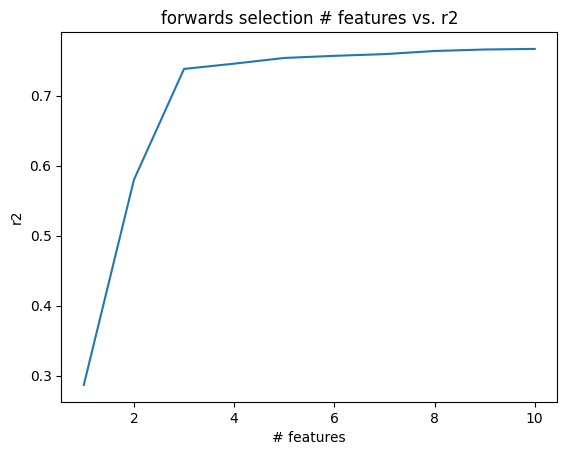

In [4]:
results = plt.plot(res.index, res['avg_score'])
plt.title('forwards selection # features vs. r2')
plt.xlabel('# features')
plt.ylabel('r2')

# increase in r2 has diminishing returns after first 3-4 features
# forwards selection identified KY1, PGV, sa10, T as the 4 most relevant features

### Backwards feature selection

In [5]:
# perform backwards feature selection to find features best for estimating displacement
y = np.log(earthquakeData['Disp'].to_numpy())
X = earthquakeData_log.drop(columns='Disp')
sfs = SFS(                              # selects one predictor at a time to create a model
    estimator = LinearRegression(),     # uses linear regression model
    k_features=1,                       # maximum size of key features
    forward=False,                      # backwards stepwise regression
    scoring="r2"                        # rates effectiveness of predictors using r-squared value
)
sfs.fit(X,y)

resBack = pd.DataFrame.from_dict(sfs.get_metric_dict()).T   # visualizes results in a pandas dataframe
resBack

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
30,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7450005930123944, 0.7710671890466383, 0.737...",0.767065,"(KY1, durav, AIav, ClstD, vs30, PGA, PGV, PGD,...",0.031879,0.024803,0.012401
29,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.7450002817145098, 0.7713496767689245, 0.737...",0.767168,"(KY1, durav, AIav, vs30, PGA, PGV, PGD, T0010S...",0.031885,0.024808,0.012404
28,"(0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0.7450865281497261, 0.7714559178727255, 0.737...",0.767272,"(KY1, AIav, vs30, PGA, PGV, PGD, T0010S, T0020...",0.031969,0.024873,0.012436
27,"(0, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, ...","[0.7450849234038266, 0.771495390978328, 0.7374...",0.767329,"(KY1, AIav, vs30, PGA, PGV, PGD, T0020S, T0050...",0.032069,0.024951,0.012475
26,"(0, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, ...","[0.7450884685242772, 0.7714792542220038, 0.737...",0.767387,"(KY1, AIav, vs30, PGA, PGV, PGD, T0020S, T0050...",0.032209,0.02506,0.01253
25,"(0, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, ...","[0.7450907836134188, 0.7715704953198248, 0.737...",0.767443,"(KY1, AIav, vs30, PGA, PGV, PGD, T0020S, T0050...",0.032211,0.025062,0.012531
24,"(0, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, ...","[0.7453337261267621, 0.7719492593248275, 0.737...",0.767467,"(KY1, AIav, vs30, PGA, PGV, PGD, T0020S, T0050...",0.032032,0.024922,0.012461
23,"(0, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, ...","[0.7452379131341554, 0.7718547334953477, 0.737...",0.767496,"(KY1, AIav, vs30, PGA, PGV, PGD, T0020S, T0050...",0.032174,0.025032,0.012516
22,"(0, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 18, ...","[0.7452452523801091, 0.7719090121832257, 0.737...",0.767513,"(KY1, AIav, vs30, PGA, PGV, PGD, T0020S, T0050...",0.032168,0.025028,0.012514
21,"(0, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 18, 19, ...","[0.7452338335250661, 0.7719049087076273, 0.737...",0.767524,"(KY1, AIav, vs30, PGA, PGV, PGD, T0020S, T0050...",0.032212,0.025062,0.012531


Text(0, 0.5, 'r2')

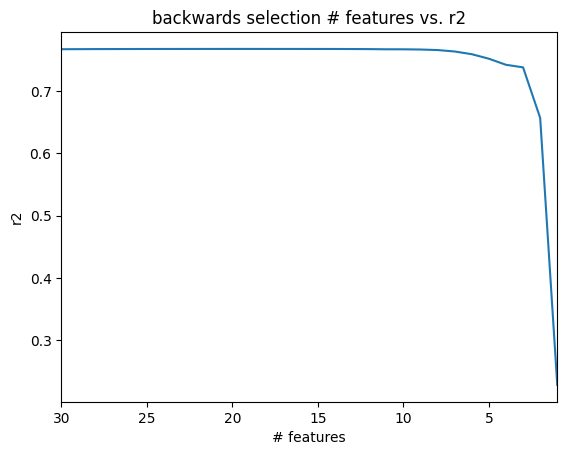

In [6]:
resultsBack = plt.plot(resBack.index, resBack['avg_score'])
plt.xlim(max(resBack.index), min(resBack.index))
plt.title('backwards selection # features vs. r2')
plt.xlabel('# features')
plt.ylabel('r2')

# r2 decreases significantly once the last 3-4 features are removed
# backwards selection identified KY1, PGV, T0050S, sa10 as the 4 most relevant features

### LASSO feature selection

In [7]:
# create training and test sets
earthquakeTraining, earthquakeTest = train_test_split(earthquakeData, test_size=0.20, random_state=770)

X_train = earthquakeTraining.drop(columns='Disp').to_numpy()
y_train = earthquakeTraining['Disp'].to_numpy()
X_test = earthquakeTest.drop(columns='Disp').to_numpy()
y_test = earthquakeTest['Disp'].to_numpy()

# create list of lambda values
lambda_values = np.logspace(-2,2,50) # create a list of candidate lambda from 10^-2 to 10^2 with 50 points in between
print(lambda_values)

# want to identify nonzero coefficients,
# standardize input X to ensure coefficients are in same scale
scaler=StandardScaler() # creates scaler for standardization
X_train_standardized = scaler.fit_transform(X_train)

# Initialize a Lasso Regression model with cross-validation
modelLASSO = LassoCV(alphas=lambda_values,cv=10, max_iter=10000) # performs 10-fold cross-validation

# Fit the model on the training set
modelLASSO.fit(X_train_standardized, y_train)

# Predict on the testing set
X_test_standardized = scaler.transform(X_test)
y_pred = modelLASSO.predict(X_test_standardized)

# get error
mse = mean_squared_error(y_pred,y_test)
print('MSE is', mse)
# check the coefficients
print('intercept is:', modelLASSO.intercept_)
earthquakeData_features = ['KY1','T','durav','AIav','M','ClstD','vs30','PGA','PGV','PGD','T0010S','T0020S','T0050S','T0070S','T0100S','T0200S','T0300S','T0400S','sa15','sa20','sa25','sa30','sa13','sa14','sa16','sa17','sa18','sa10','sa11','sa12','Disp']
print('coefficients are:', list(zip(modelLASSO.coef_, earthquakeData_features)))

# find optimal alpha/lambda value
print('optimal lambda is', modelLASSO.alpha_)

[1.00000000e-02 1.20679264e-02 1.45634848e-02 1.75751062e-02
 2.12095089e-02 2.55954792e-02 3.08884360e-02 3.72759372e-02
 4.49843267e-02 5.42867544e-02 6.55128557e-02 7.90604321e-02
 9.54095476e-02 1.15139540e-01 1.38949549e-01 1.67683294e-01
 2.02358965e-01 2.44205309e-01 2.94705170e-01 3.55648031e-01
 4.29193426e-01 5.17947468e-01 6.25055193e-01 7.54312006e-01
 9.10298178e-01 1.09854114e+00 1.32571137e+00 1.59985872e+00
 1.93069773e+00 2.32995181e+00 2.81176870e+00 3.39322177e+00
 4.09491506e+00 4.94171336e+00 5.96362332e+00 7.19685673e+00
 8.68511374e+00 1.04811313e+01 1.26485522e+01 1.52641797e+01
 1.84206997e+01 2.22299648e+01 2.68269580e+01 3.23745754e+01
 3.90693994e+01 4.71486636e+01 5.68986603e+01 6.86648845e+01
 8.28642773e+01 1.00000000e+02]
MSE is 1294.729236190965
intercept is: 16.600544628457747
coefficients are: [(-22.166971921293182, 'KY1'), (1.3865361436706953, 'T'), (0.5845205061725005, 'durav'), (3.3637314705252916, 'AIav'), (3.0773289924452296, 'M'), (-3.6071626303

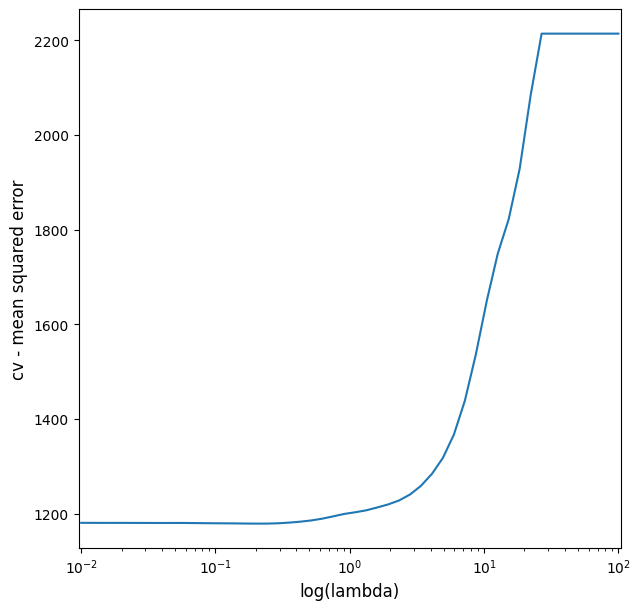

In [13]:
# plot lambdas
fig,ax=plt.subplots(figsize=(7,7))
ax.plot(modelLASSO.alphas_, np.mean(modelLASSO.mse_path_,axis=1))
ax.set_xscale('log')
ax.set_xlabel('log(lambda)', fontsize=12)
ax.set_ylabel('cv - mean squared error', fontsize=12)
ax.margins(x=0.005)

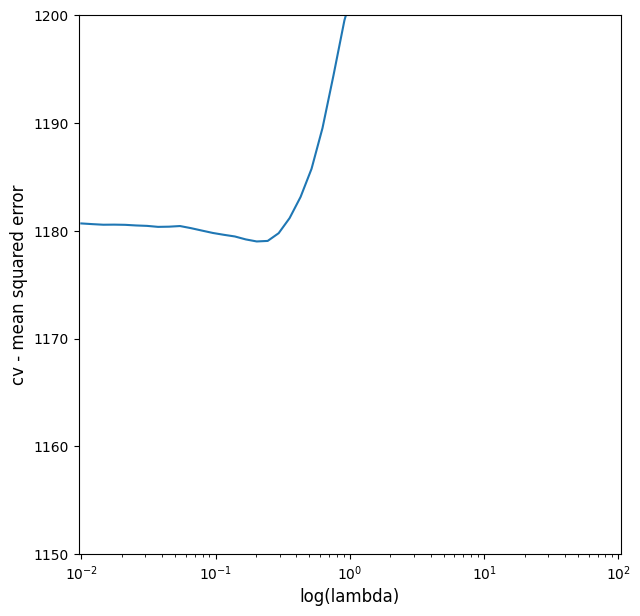

In [15]:
# zoom in on absolute minimum
fig,ax=plt.subplots(figsize=(7,7))
ax.plot(modelLASSO.alphas_, np.mean(modelLASSO.mse_path_,axis=1))
ax.set_xscale('log')
ax.set_xlabel('log(lambda)', fontsize=12)
ax.set_ylabel('cv - mean squared error',fontsize=12)
ax.set_ybound(1150, 1200)
ax.set_xbound(0.01, 10)
ax.margins(x=0.005)